In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from scipy import stats

In [2]:
data = pd.read_csv("playlists.csv", sep=";", encoding = "ISO-8859-1") 

In [3]:
data.describe(include="all")

,company,playlist_sample,namesfiles,no,artist,song,sampleratefiles,totalsamplesfiles,durationfiles,bitratefiles,...,chromagramfiles_5,chromagramfiles_6,chromagramfiles_7,chromagramfiles_8,chromagramfiles_9,chromagramfiles_10,chromagramfiles_11,chromagramfiles_12,attackslopefiles,attackleapfiles
count,1782,1782.000000,1782,1782.000000,1782,1782,1782.0,1.782000e+03,1782.000000,1782.000000,...,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000
unique,6,NaN,515,NaN,353,443,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Arte Francés,NaN,"21 - Galantis, Uffie - Spaceship (feat. Uffie)...",NaN,Satin Jackets,Mirage.mp3 ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,441,NaN,6,NaN,51,12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.084175,NaN,17.116162,NaN,NaN,44100.0,1.043632e+07,236.651237,252.336700,...,0.332301,0.319191,0.265246,0.440462,0.549565,0.581967,0.477825,0.430522,15.804409,0.507503
std,NaN,1.114796,NaN,11.837401,NaN,NaN,0.0,3.227105e+06,73.176981,88.377597,...,0.270616,0.263919,0.249612,0.290454,0.314771,0.323173,0.321646,0.295563,9.338659,0.247587
min,NaN,1.000000,NaN,1.000000,NaN,NaN,44100.0,5.965054e+06,135.262000,128.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168304
25%,NaN,1.000000,NaN,8.000000,NaN,NaN,44100.0,8.353151e+06,189.413850,128.000000,...,0.116591,0.109123,0.075378,0.204738,0.301961,0.316822,0.214680,0.203097,9.810711,0.285584
50%,NaN,2.000000,NaN,15.500000,NaN,NaN,44100.0,9.480378e+06,214.974562,320.000000,...,0.262799,0.259887,0.183082,0.396861,0.520957,0.570088,0.418077,0.379737,14.833864,0.452456
75%,NaN,3.000000,NaN,24.000000,NaN,NaN,44100.0,1.146931e+07,260.075075,320.000000,...,0.494897,0.469603,0.384485,0.642814,0.829318,0.918554,0.735384,0.616558,19.964413,0.730669


Find positives and negatives songs of the process for every company.

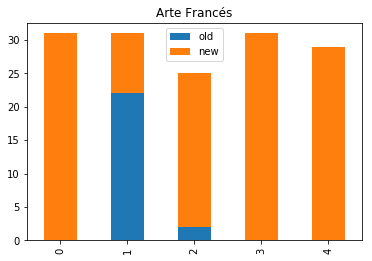

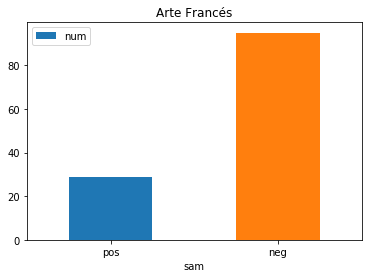

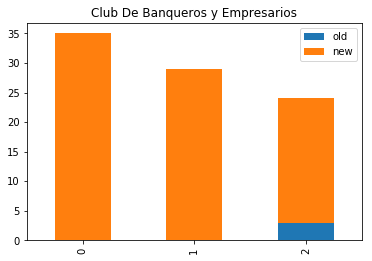

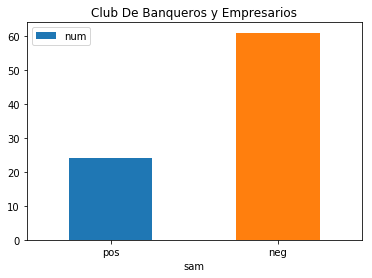

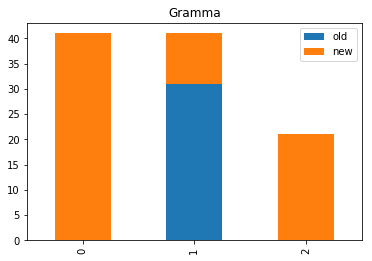

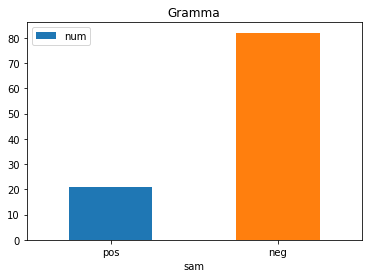

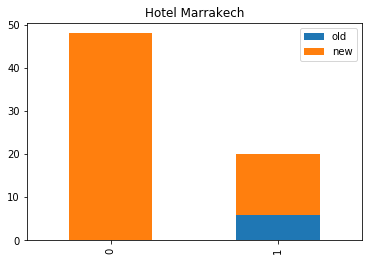

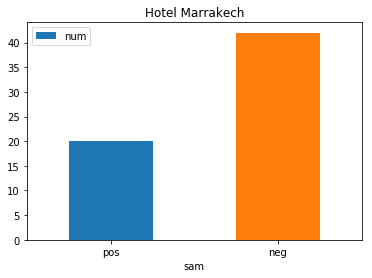

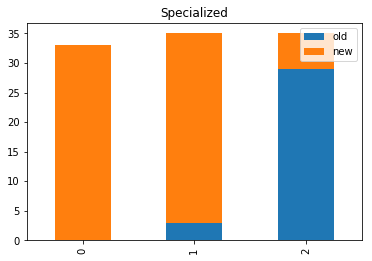

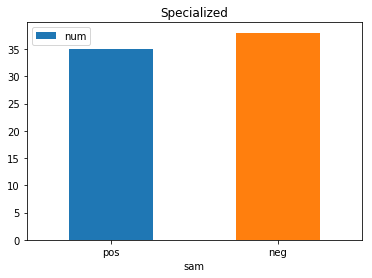

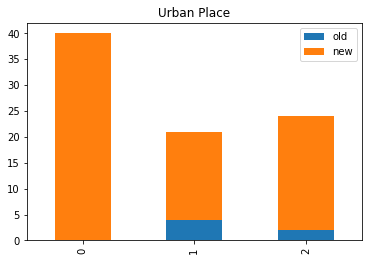

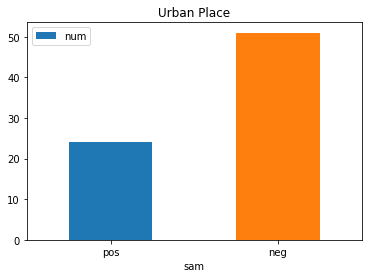

In [5]:
companies = data['company'].unique()
by_company = [data[data.company == company] for company in companies]
positives = []
negatives = []
for data_com in by_company:
    data_com = data_com.sort_values('playlist_sample')
    last_pl = int(data_com.tail(1).playlist_sample)
    pls = pd.DataFrame({'pl':range (1,last_pl+1), 'old':[0]*last_pl, 'new':[0]*last_pl})
    pls.new[0]=(data_com.query('playlist_sample == '+str(1)).shape[0])/3
    for i in range(2,last_pl+1):
        curr_pl = data_com.query('playlist_sample == '+str(i))
        pre_pl = data_com.query('playlist_sample == '+str(i-1))
        olds = curr_pl['song'].map(pre_pl['song'].value_counts()).sum(axis = 0)/3
        pls.old[i-1]= olds/3 
        pls.new[i-1]=(curr_pl.shape[0]-olds)/3
    pls[['old','new']].plot(kind='bar', stacked=True, title=data_com.iloc[0,0])
    df_last_pl= data_com.query('playlist_sample == '+str(last_pl))
    positives.append(df_last_pl)
    pos_loc = pd.DataFrame({}, columns=data_com.columns)
    for index, row in data_com[data_com.playlist_sample<last_pl].iterrows(): 
        if not ((df_last_pl['artist'] == row['artist']) & (df_last_pl['song'] ==  row['song'])).any():
            pos_loc= pos_loc.append(row, ignore_index=True)
    n_vs_p = pd.DataFrame({'sam':['pos', 'neg'],'num':[df_last_pl.shape[0]/3,pos_loc.shape[0]/3]})
    n_vs_p.plot.bar(x='sam', y='num', rot=0, title=data_com.iloc[0,0])
    negatives.append(pos_loc)

In [6]:
df_n_ps = []
for i in range(len(negatives)):
    negatives[i]['chosen']=0
    positives[i]['chosen']=1
    df_n_ps.append(negatives[i].append(positives[i]))

D:\Usuarios\1144084318\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## ANOVA

In [8]:
import warnings
import matplotlib.pyplot as plt
import math
import seaborn as sns
warnings.filterwarnings('ignore')

<Figure size 1224x14400 with 0 Axes>

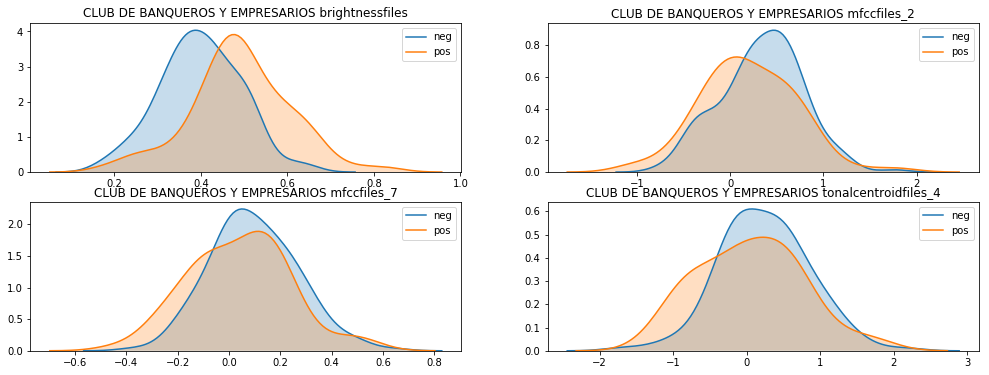

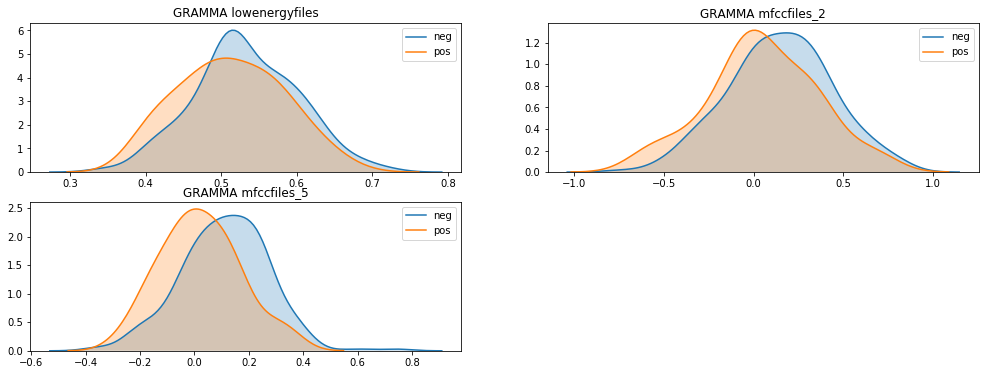

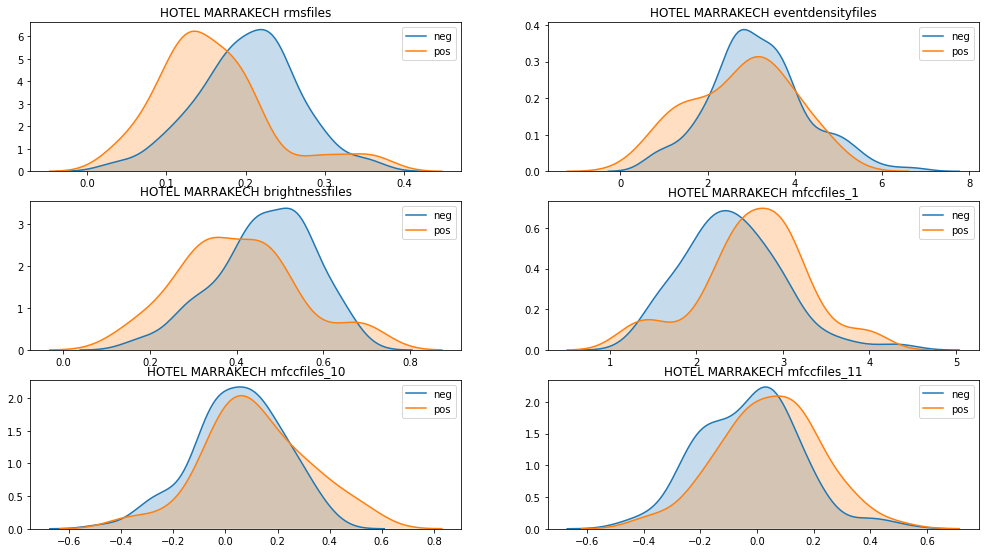

<Figure size 1224x14400 with 0 Axes>

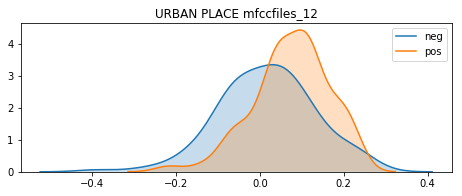

In [22]:
alpha = 0.05
for df_n_p in df_n_ps:
    df_n_p = df_n_p.fillna(0)
    fig = plt.figure(figsize=(17,200))
    i=1
    for index in range(8,df_n_p.shape[1]-1):
        name= df_n_p.columns.values[index]
        df_n_p[name]=df_n_p[name].astype('float64') 
        mc = MultiComparison(df_n_p[name], df_n_p['chosen'])
        mc_results = mc.tukeyhsd()
        if mc_results._results_table.data[1:][0][5]:
            # print(name)
            results = ols(name+' ~ C(chosen)', data=df_n_p).fit()
            homogeneity_test = stats.levene(df_n_p[name][df_n_p['chosen'] == 0], df_n_p[name][df_n_p['chosen'] == 1])[1]
            normality_test = stats.shapiro(results.resid)[1]
            if homogeneity_test > alpha and normality_test > alpha:
                # print(results.summary())
                ax = fig.add_subplot(math.ceil(df_n_p.shape[1]-9/2), 2, i)
                sns.kdeplot(df_n_p.loc[df_n_p.chosen==0][name], shade=True, ax=ax);
                sns.kdeplot(df_n_p.loc[df_n_p.chosen==1][name], shade=True, ax=ax);
                plt.title(df_n_p.iloc[0,0].upper()+" "+name)
                plt.legend(['neg', 'pos'])
                i+=1

# MFCC